# Training Models with most Important  Features
The aim of this notebooks is to evaluate the impact of training models only with the most important features. The most important features are considered to be the ones that obtain the highest MI scores addressed in the `feature_engineering.ipynb` notebook. For now, only the 4 most important features are considered. The dataset considered will be the one created in the `feature_engineering.ipynb` notebook.

The best features for high voltage constraints are:
- $cos(\text{hour})$: Cosine of hour of day.
- $R$: Forecasted Irradince, measure in $W/m^2$.
- $\text{last hour mean irradiance}$: Mean irradiance of the last hour.
- $T$: Temperatura in Kelvins.

After training Linear Regression and Gradient Boost Regression models, the evaluation will be perfomed by using the metric implemented in `ml_hybrid_metrics.ipynb`.

**Summary of this article**
- Input the exogneous data previously treated and explored.
- Train the Linear Regression and Gradient Boost Regression models with
    - All the datasets features 
    - Only with the most relevant features.
- Evaluate the models with the metric implemented in `ml_hybrid_metrics.ipynb`.

### Data

The dataset is the one created in the `feature_engineering.ipynb` notebook. It contains features that are external to the network, such as Temperature and $cos(hour)$.

In [1]:
# Data 
import pandas as pd
output = pd.read_csv('..\data\ground_truth\pf_res_bus_vm_pu.csv')
# create a timestamps variable and convert it to datetime
timestamps = output['timestamps'].apply(lambda x: pd.to_datetime(x))
output.drop(['timestamps'], axis=1, inplace=True)
output = output.apply(lambda x: (0.95 - x).apply(lambda y: max(0, y)))
#Training data
_exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv')

The features are:

In [2]:
_exogenous_data.columns

Index(['T', 'R', 'date', 'wind_speed', 'wind_direction', 'season', 'weekday',
       'last_hour_mean_wind_speed', 'last_day_mean_wind_direction',
       'last_hour_mean_temperature', 'cos_hour_day',
       'last_hour_mean_irradiance'],
      dtype='object')

From the `feature_engineering.ipynb` notebook it was possible to identify the most important features to be used in the model, by using calculateing the *MI scores* of the features. In this present article we will use the 4 most important features to train the models.

In [3]:
exogenous_data_most_relevant = _exogenous_data.loc[:, ['T', 'R', 'last_hour_mean_irradiance', 'cos_hour_day']]
exogenous_data_complete = _exogenous_data.drop('date', axis=1)

### Traning Models
In this section both models, Linear Regression and Gradient Boost Regression, will be trained with the different datasets. In terms of train test splitting the dataset, the full dataset will be split into train and test datasets with a 80% and 20% respectively. The train dataset will be suffled for training.

#### All Features Dataset

In [4]:
import sys
sys.path.append('..')
from thesis_package import aimodels as my_ai, utils
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
import os
le = LabelEncoder()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(exogenous_data_complete, output, test_size=0.2, shuffle=False)
# Shuffle the data
X_train, y_train = shuffle(X_train, y_train)
# Linear Regression
X_train['season'] = le.fit_transform(X_train['season'])
X_test['season'] = le.fit_transform(X_test['season'])   
if 'regressor_all_features.pickle' not in os.listdir():
    regressor_all_features = my_ai.Context(strategy=my_ai.LinearRegressionStrategy())
    regressor_all_features.fit(data={'X_train': X_train, 'y_train': y_train})
    # Gradient Boost Regression
    hyper_params = {'n_estimators': 1000, 'learning_rate': 0.1, 'loss': 'squared_error'}
    regressor_all_features.strategy = my_ai.GradientBoostRegressorStrategy(hyper_params)
    regressor_all_features.fit(data={'X_train': X_train.values, 'y_train': y_train.values})
    utils.serialize_object('regressor_all_features', regressor_all_features)
else: 
    regressor_all_features = utils.deserialize_object('regressor_all_features')
prediction_lr_all_features = regressor_all_features.strategies[0].predict(data={'X_test': X_test})
prediction_lr_all_features = pd.DataFrame(prediction_lr_all_features , columns=y_test.columns)
prediction_gb_all_features =  regressor_all_features.strategies[1].predict(data={'X_test': X_test})
prediction_gb_all_features = pd.DataFrame(prediction_gb_all_features, columns=y_test.columns)

c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without

#### Most Relevant Features Dataset

In [6]:
X_train, X_test, y_train, y_test = train_test_split(exogenous_data_most_relevant, output, test_size=0.2, shuffle=False)
# Shuffle the data
X_train, y_train = shuffle(X_train, y_train)
if 'regressor_most_important_features.pickle' not in os.listdir():
    # Linear Regression
    regressor_most_important_features = my_ai.Context(strategy=my_ai.LinearRegressionStrategy())
    regressor_most_important_features.fit(data={'X_train': X_train, 'y_train': y_train})
    # Gradient Boost Regression
    hyper_params = {'n_estimators': 1000, 'learning_rate': 0.1, 'loss': 'squared_error'}
    regressor_most_important_features.strategy = my_ai.GradientBoostRegressorStrategy(hyper_params)
    regressor_most_important_features.fit(data={'X_train': X_train.values, 'y_train': y_train.values})
    utils.serialize_object('regressor_most_important_features', regressor_most_important_features)
else:
    regressor_most_important_features = utils.deserialize_object('regressor_most_important_features')
prediction_lr_most_important_features = regressor_most_important_features.strategies[0].predict(data={'X_test': X_test})
prediction_lr_most_important_features = pd.DataFrame(prediction_lr_most_important_features , columns=y_test.columns)
prediction_gb_most_important_features =  regressor_most_important_features.strategies[1].predict(data={'X_test': X_test.values})
prediction_gb_most_important_features = pd.DataFrame(prediction_gb_most_important_features, columns=y_test.columns)

### Evaluating Models
In this section the results using the two datasets will be compared for both models trained. The TP, TN, FP, FN, Accuracy, Precision, Recall, F1 Score will be plot and compared.

The evaluation in done by using the metric implemented in `ml_hybrid_metrics.ipynb`. The threshold percentage for the metrics will be set to 10%, as concluded in the ml_hybrid_metrics.ipynb notebook.


In [7]:
import numpy as np
from thesis_package import metrics 
metric = metrics.Metrics()
threshold = output.loc[:, output.max(axis=0) != 0].max(axis=0).mean() * 0.1 
# Signal the same length of the index of y_test, with a constant value of threshold.
threshold_signal = pd.Series(np.ones([2000]) * threshold)

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

#### Linear Regression

True positives RMSE: 0.009337041504298064
False positives RMSE: 0.0021737054632497755
False negatives RMSE: 0.006630217583049774
True negatives RMSE: 0.00032325434036249473
Recall: 0.2335997335997336 
 TP: 1403, FN: 4603
Accuracy: 0.9800582771808414 
 TP: 1403, FP: 1529, TN: 299961, FN: 4603
Precision: 0.47851296043656205 
 TP: 1403, FP: 1529
F1 score: 0.31394047885432985 
 Precision: 0.47851296043656205, Recall: 0.2335997335997336
True positives RMSE: 0.007719377243632767
False positives RMSE: 0.0024114237228672463
False negatives RMSE: 0.006652104455375163
True negatives RMSE: 0.0003831805017423005
Recall: 0.3997668997668998 
 TP: 2401, FN: 3605
Accuracy: 0.9712711710071026 
 TP: 2401, FP: 5229, TN: 296261, FN: 3605
Precision: 0.3146788990825688 
 TP: 2401, FP: 5229
F1 score: 0.35215605749486656 
 Precision: 0.3146788990825688, Recall: 0.3997668997668998


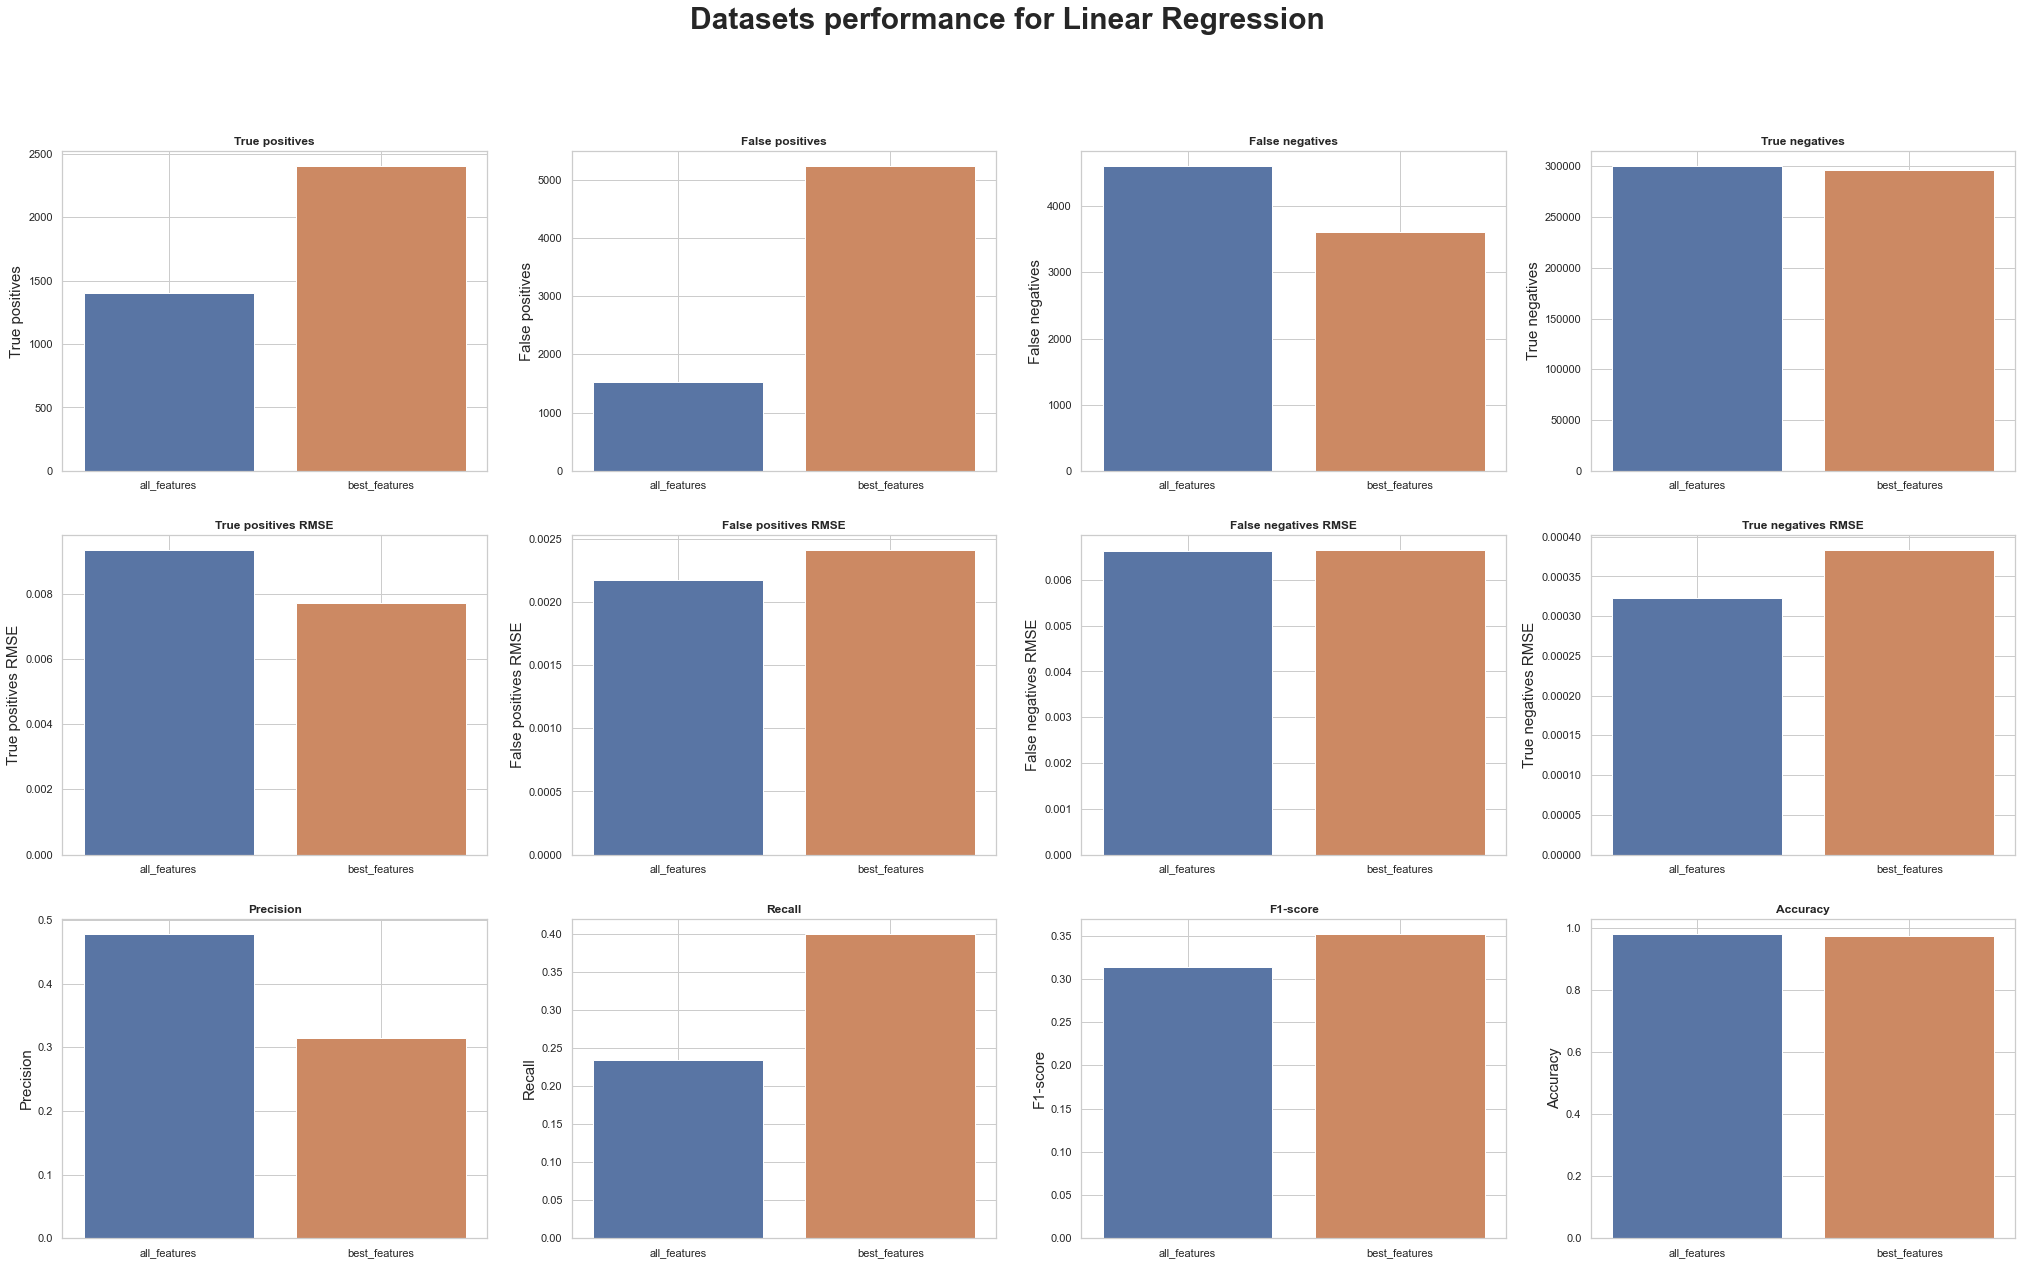

In [19]:
# Input
all_features_prediction = prediction_lr_all_features
best_features_prediction = prediction_lr_most_important_features
# Function
def plot_results(all_features_prediction, best_features_prediction, model):
    metric.get_prediction_scores(all_features_prediction, y_test, threshold=threshold)
    tp_all_features, fp_all_features, fn_all_features, tn_all_features = metric.true_positives_ctr, metric.false_positives_ctr, metric.false_negatives_ctr, metric.true_negatives_ctr
    metric.get_report()
    tp_rmse_all_features, fp_rmse_all_features, fn_rmse_all_features, tn_rmse_all_features = metric.true_positives_rmse, metric.false_positives_rmse, metric.false_negatives_rmse, metric.true_negatives_rmse
    precision_all_features, accuracy_all_features, recall_all_features, f1_score_all_features = metric.precision, metric.accuracy, metric.recall, metric.f1_score
    # same for best features
    metric.get_prediction_scores(best_features_prediction, y_test, threshold=threshold)
    tp_best_features, fp_best_features, fn_best_features, tn_best_features = metric.true_positives_ctr, metric.false_positives_ctr, metric.false_negatives_ctr, metric.true_negatives_ctr
    metric.get_report()
    tp_rmse_best_features, fp_rmse_best_features, fn_rmse_best_features, tn_rmse_best_features = metric.true_positives_rmse, metric.false_positives_rmse, metric.false_negatives_rmse, metric.true_negatives_rmse
    precision_best_features, accuracy_best_features, recall_best_features, f1_score_best_features = metric.precision, metric.accuracy, metric.recall, metric.f1_score
    # Create dataframe with the results
    index = ['all_features', 'best_features']
    columns = ['tp', 'fp', 'fn', 'tn', 'tp_rmse', 'fp_rmse', 'fn_rmse', 'tn_rmse']
    results = pd.DataFrame(index=index, columns=columns)
    results.loc['all_features', 'tp'] = tp_all_features
    results.loc['all_features', 'fp'] = fp_all_features
    results.loc['all_features', 'fn'] = fn_all_features
    results.loc['all_features', 'tn'] = tn_all_features
    results.loc['all_features', 'tp_rmse'] = tp_rmse_all_features
    results.loc['all_features', 'fp_rmse'] = fp_rmse_all_features
    results.loc['all_features', 'fn_rmse'] = fn_rmse_all_features
    results.loc['all_features', 'tn_rmse'] = tn_rmse_all_features
    results.loc['all_features', 'precision'] = precision_all_features
    results.loc['all_features', 'accuracy'] = accuracy_all_features
    results.loc['all_features', 'recall'] = recall_all_features
    results.loc['all_features', 'f1_score'] = f1_score_all_features
    results.loc['best_features', 'tp'] = tp_best_features
    results.loc['best_features', 'fp'] = fp_best_features
    results.loc['best_features', 'fn'] = fn_best_features
    results.loc['best_features', 'tn'] = tn_best_features
    results.loc['best_features', 'tp_rmse'] = tp_rmse_best_features
    results.loc['best_features', 'fp_rmse'] = fp_rmse_best_features
    results.loc['best_features', 'fn_rmse'] = fn_rmse_best_features
    results.loc['best_features', 'tn_rmse'] = tn_rmse_best_features
    results.loc['best_features', 'precision'] = precision_best_features
    results.loc['best_features', 'accuracy'] = accuracy_best_features
    results.loc['best_features', 'recall'] = recall_best_features
    results.loc['best_features', 'f1_score'] = f1_score_best_features
    # Plot the results in a bar chart using seaborn. One subplot with the tp, fp, fn, tn and the other with the rmse.
    fig, axs = plt.subplots(3, 4, figsize=(35, 20))
    # Set whitegrid style
    sns.set(style='whitegrid')
    # TP, FP, FN, TN
    sns.barplot(x=results.index, y='tp', data=results, ax=axs[0, 0])
    sns.barplot(x=results.index, y='fp', data=results, ax=axs[0, 1])
    sns.barplot(x=results.index, y='fn', data=results, ax=axs[0, 2])
    sns.barplot(x=results.index, y='tn', data=results, ax=axs[0, 3])
    # RMSE values
    sns.barplot(x=results.index, y='tp_rmse', data=results, ax=axs[1, 0])
    sns.barplot(x=results.index, y='fp_rmse', data=results, ax=axs[1, 1])
    sns.barplot(x=results.index, y='fn_rmse', data=results, ax=axs[1, 2])
    sns.barplot(x=results.index, y='tn_rmse', data=results, ax=axs[1, 3])
    # Precision, recall, f1-score, accuracy
    sns.barplot(x=results.index, y='precision', data=results, ax=axs[2, 0])
    sns.barplot(x=results.index, y='recall', data=results, ax=axs[2, 1])
    sns.barplot(x=results.index, y='f1_score', data=results, ax=axs[2, 2])
    sns.barplot(x=results.index, y='accuracy', data=results, ax=axs[2, 3])
    # Set title in bold and labels for the subplots
    axs[0, 0].set_title('True positives', fontweight='bold')
    axs[0, 1].set_title('False positives', fontweight='bold')
    axs[0, 2].set_title('False negatives', fontweight='bold')
    axs[0, 3].set_title('True negatives', fontweight='bold')
    axs[1, 0].set_title('True positives RMSE', fontweight='bold')
    axs[1, 1].set_title('False positives RMSE', fontweight='bold')
    axs[1, 2].set_title('False negatives RMSE', fontweight='bold')
    axs[1, 3].set_title('True negatives RMSE', fontweight='bold')
    axs[2, 0].set_title('Precision', fontweight='bold')
    axs[2, 1].set_title('Recall', fontweight='bold')
    axs[2, 2].set_title('F1-score', fontweight='bold')
    axs[2, 3].set_title('Accuracy', fontweight='bold')
    # Set labels for the subplots
    axs[0, 0].set_ylabel('True positives')
    axs[0, 1].set_ylabel('False positives')
    axs[0, 2].set_ylabel('False negatives')
    axs[0, 3].set_ylabel('True negatives')
    axs[1, 0].set_ylabel('True positives RMSE')
    axs[1, 1].set_ylabel('False positives RMSE')
    axs[1, 2].set_ylabel('False negatives RMSE')
    axs[1, 3].set_ylabel('True negatives RMSE')
    axs[2, 0].set_ylabel('Precision')
    axs[2, 1].set_ylabel('Recall')
    axs[2, 2].set_ylabel('F1-score')
    axs[2, 3].set_ylabel('Accuracy')
    # Set the fontsize for the labels
    for ax in axs.flat:
        ax.set_xlabel(ax.get_xlabel(), fontsize=15)
        ax.set_ylabel(ax.get_ylabel(), fontsize=15)
    # Set grid on to all subplots
    for ax in axs.flat:
        ax.grid(True)
    # Set the fontsize for the title
    fig.suptitle('Datasets performance for {}'.format(model), fontsize=30, fontweight='bold')
plot_results(all_features_prediction, best_features_prediction, model='Linear Regression')


From the plots above, it is possible to observe that:
- *Positive Values*:
    - The `best_features` result yields more *Positive* values. Both *TP* and *FP* are higher.
- *Negative Values*:
    - The `best_features` result yields less *FN* and a similar number of *TN*.
- Since the `best_features` yields more *TP* and less *FP*, it contains a greater recall, however it also yields way more *FP*, it has a lower precision when compared to the `all_features model`. However in terms of F1 Score, the `best_features` model is better than the `all_features model`.
- The `best_features` presents a lower *TP_rmse* but a equal or higher *rmse* for all the other metrics.

#### Gradient Boost Regression

True positives RMSE: 0.004887990081927983
False positives RMSE: 0.00309397541496717
False negatives RMSE: 0.00372956583491728
True negatives RMSE: 0.00021752202474917474
Recall: 0.7254412254412255 
 TP: 4357, FN: 1649
Accuracy: 0.9870177173036397 
 TP: 4357, FP: 2343, TN: 299147, FN: 1649
Precision: 0.6502985074626866 
 TP: 4357, FP: 2343
F1 score: 0.6858177239099638 
 Precision: 0.6502985074626866, Recall: 0.7254412254412255
True positives RMSE: 0.004055805457080855
False positives RMSE: 0.003934314816516162
False negatives RMSE: 0.00369399200801985
True negatives RMSE: 0.0002062779089893513
Recall: 0.7847152847152847 
 TP: 4713, FN: 1293
Accuracy: 0.9843640242474699 
 TP: 4713, FP: 3515, TN: 297975, FN: 1293
Precision: 0.5728001944579485 
 TP: 4713, FP: 3515
F1 score: 0.662217226359421 
 Precision: 0.5728001944579485, Recall: 0.7847152847152847


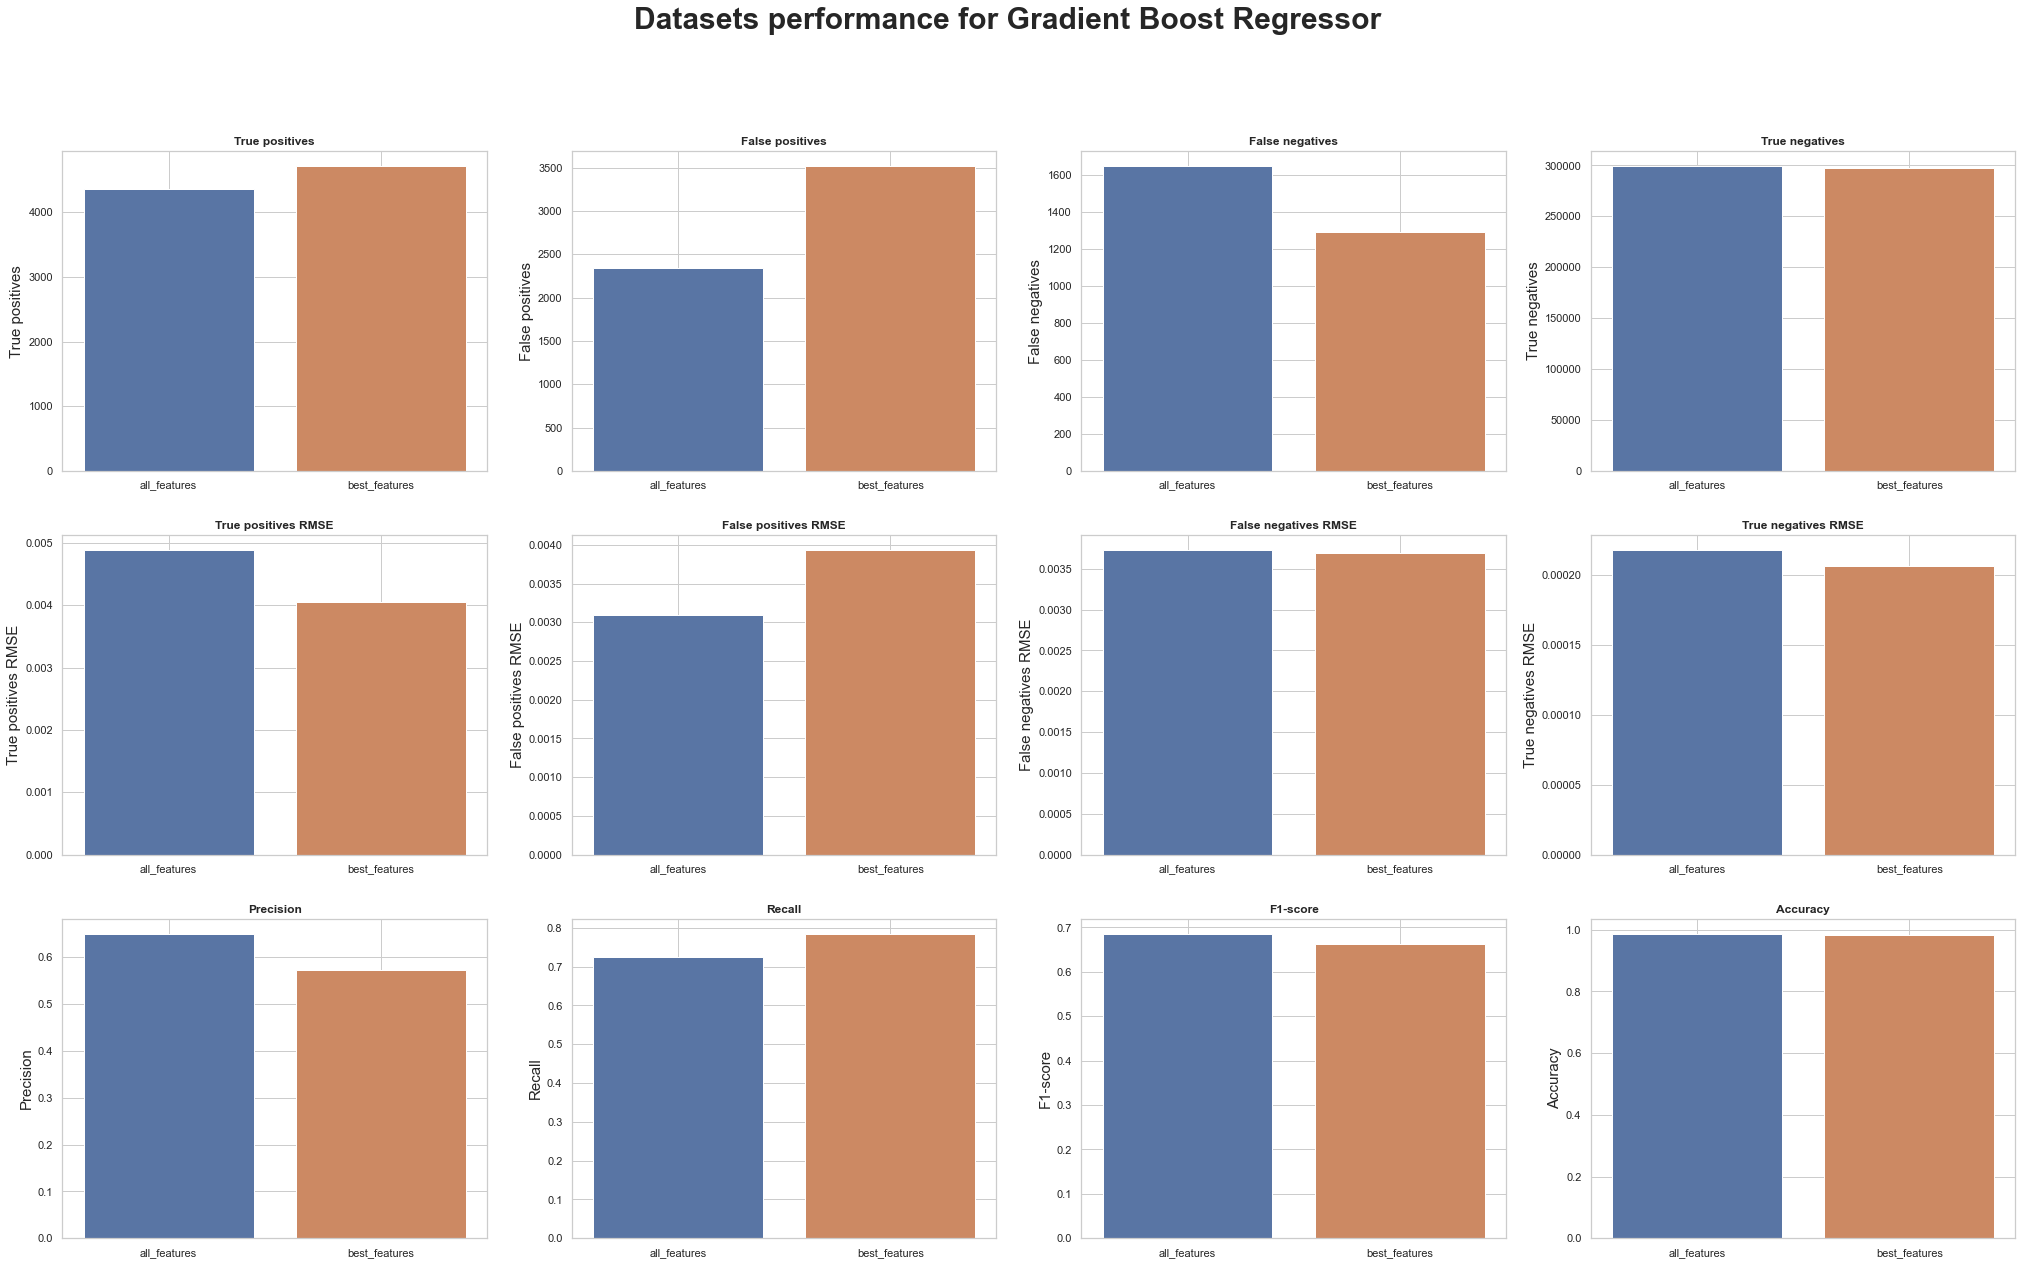

In [ ]:
all_features_prediction = prediction_gb_all_features
best_features_prediction = prediction_gb_most_important_features
plot_results(all_features_prediction, best_features_prediction, model='Gradient Boost Regressor')

- *Positive Values*:
    - The `best_features` result yields more *Positive* values. Both *TP* and *FP* are higher.
- *Negative Values*:
    - The `best_features` result yields less *FN* and a similar number of *TN*.
- Since the `best_features` yields more *TP* and less *FP*, it contains a greater recall, however it also yields way more *FP*, it has a lower precision when compared to the `all_features model`. In terms of F1 Score, the `best_features` model is worse than the `all_features model`.
- The `best_features` presents a lower *TP_rmse* but a equal or higher *rmse* for all the other metrics.